### Telecom Churn Case Study

In [1]:
#Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore") 

#### Importing the data and data exploration

In [2]:
# Importing the data
telecom = pd.read_csv("telecom_churn_data.csv")
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
# Data exploration
telecom.shape

(99999, 226)

- The dataset contains 99999 rows and 226 columns

In [4]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


#### Filtering High Value Customers

In [5]:
# High value customers according to problem statement : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
# Amount spent by the customers on data recharge can be calculated by multiplying the columns av_rech_amt_data_x and total_rech_data_x ; where x corresponds to month 6/7/8
telecom["total_rech_d_amt_6"] = telecom["av_rech_amt_data_6"] * telecom["total_rech_data_6"]
telecom["total_rech_d_amt_7"] = telecom["av_rech_amt_data_7"] * telecom["total_rech_data_7"]
telecom["total_rech_d_amt_8"] = telecom["av_rech_amt_data_8"] * telecom["total_rech_data_8"]
telecom["total_rech_d_amt_9"] = telecom["av_rech_amt_data_9"] * telecom["total_rech_data_9"]

In [6]:
# Dropping columns av_rech_amt_data_x & total_rech_data_x where x is month 6,7,8 & 9.
telecom.drop(["av_rech_amt_data_6", "av_rech_amt_data_7", "av_rech_amt_data_8","av_rech_amt_data_9","total_rech_data_6","total_rech_data_7","total_rech_data_8","total_rech_data_9"], axis=1, inplace = True)

In [7]:
# Average recharge done in the good phase i.e in the month of June and July
telecom_rech_gphase = (telecom['total_rech_amt_6'].fillna(0) + telecom['total_rech_amt_7'].fillna(0) + telecom['total_rech_d_amt_6'].fillna(0) + telecom['total_rech_d_amt_7'].fillna(0))/2

In [8]:
# 70th percentile of the data
percentile = np.percentile(telecom_rech_gphase, 70.0)
print("70th percentile is :", percentile)

70th percentile is : 478.0


In [9]:
# Filetring the data as per the problem statement
telecom_hv_cust = telecom[telecom_rech_gphase >= percentile]
print("Dimensions of the filtered dataset:",telecom_hv_cust.shape)

Dimensions of the filtered dataset: (30001, 222)


#### Tagging churners and removing attributes of the churn phase

In [10]:
# Churned customers (churn=1, else 0) are based on the fourth month : Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase.
telecom_hv_cust["churn"] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1)==0, 1,0)
telecom_hv_cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_d_amt_6,total_rech_d_amt_7,total_rech_d_amt_8,total_rech_d_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0


In [11]:
telecom_hv_cust["churn"].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

- 91.86% of the population are non-churners while 8.13% fall under chaurning population. This is a case of class imbalance. 

In [12]:
# Checking variance in the columns and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"has no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Dropping the column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimension of the updated dataset:",telecom_hv_cust.shape)


Column circle_id has no variance and contains only 1 unique value
Dropping the column circle_id

Column loc_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_og_t2o_mou

Column std_og_t2o_mou has no variance and contains only 1 unique value
Dropping the column std_og_t2o_mou

Column loc_ic_t2o_mou has no variance and contains only 1 unique value
Dropping the column loc_ic_t2o_mou

Column last_date_of_month_6 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_6

Column last_date_of_month_7 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_7

Column last_date_of_month_8 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_8

Column last_date_of_month_9 has no variance and contains only 1 unique value
Dropping the column last_date_of_month_9

Column std_og_t2c_mou_6 has no variance and contains only 1 unique value
Dropping the column std_og_t2c_m

In [13]:
# Checking nulls in the dataset
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [14]:
# Dropping columns with more than 30% missing values except 9th month columns
cols = telecom_hv_cust.columns
telecom_null_perc = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,
                                 'perc_null': telecom_null_perc})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 30.0)]["col_name"]
print("list of columns dropped:",drop_cols)

# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)
telecom_hv_cust.shape

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

(30001, 180)

In [15]:
obj_data = telecom_hv_cust.select_dtypes(include = ["object"])
print(obj_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [16]:
# Converting the above columns to date format
for col in obj_data.columns:
    telecom_hv_cust[col]=pd.to_datetime(telecom_hv_cust[col])

In [17]:
telecom_hv_cust.head()

,mobile_number,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,...,sachet_3g_8,sachet_3g_9,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_d_amt_9,churn
0,7000842753,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,...,0,0,NaN,968,30.40,0.00,101.20,3.58,NaN,1
7,7000701601,1069.180,1349.850,3171.480,500.000,57.84,54.68,52.29,NaN,453.43,...,0,0,NaN,802,57.74,19.38,18.74,0.00,NaN,1
8,7001524846,378.721,492.223,137.362,166.787,413.69,351.03,35.08,33.46,94.66,...,0,0,NaN,315,21.03,910.65,122.16,0.00,NaN,0
21,7002124215,514.453,597.753,637.760,578.596,102.41,132.11,85.14,161.63,757.93,...,0,0,NaN,720,0.00,0.00,0.00,0.00,NaN,0
23,7000887461,74.350,193.897,366.966,811.480,48.96,50.66,33.58,15.74,85.41,...,1,0,1.0,604,40.45,51.86,0.00,0.00,252.0,0


In [18]:
# Checking correlation amongst the features and subsequently dropping the highly correlated ones
cor = telecom_hv_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [19]:
# Dropping the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

(30001, 125)

In [20]:
# Now we will delete 9th month columns because we would predict churn/non-churn later based on data from the 1st 3 months
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)

telecom_hv_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_d_amt_9']


(30001, 88)

In [21]:
# drop rows with null values
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_8'])]

In [22]:
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

#### Feature Engineering

In [23]:
# create a new colulmn, which would be average of 6th & 7th month
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)

# lets take the average now
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2

(28504, 88)


In [24]:
# Dropping unnnecsary columns
col_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_drop, axis=1, inplace = True)

In [25]:
# Converting Age on network to months

telecom_hv_cust["aon_month"] = telecom_hv_cust["aon"]/30
telecom_hv_cust.drop('aon', axis=1, inplace = True)
telecom_hv_cust["aon_month"].head()

7     26.733333
8     10.500000
21    24.000000
23    20.133333
33    44.266667
Name: aon_month, dtype: float64

#### Exploratory Data Analysis

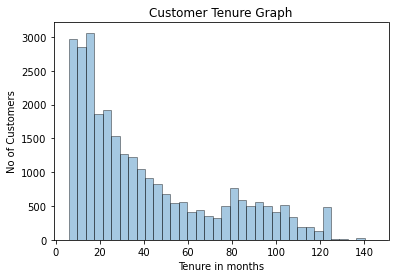

In [26]:
# Customer Tenure Graph
cust_tenure = sns.distplot(telecom_hv_cust['aon_month'], hist=True, kde=False, bins=int(180/5), hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 12})
cust_tenure.set_ylabel('No of Customers')
cust_tenure.set_xlabel('Tenure in months')
cust_tenure.set_title('Customer Tenure Graph')
plt.show()

- Custumers having a tenure of less than 4 years are more likely to churn

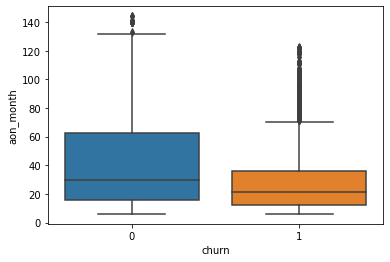

In [27]:
sns.boxplot(x=telecom_hv_cust.churn, y=telecom_hv_cust.aon_month)
plt.show()

- Tenured customers are not churning and are readily availing the services 

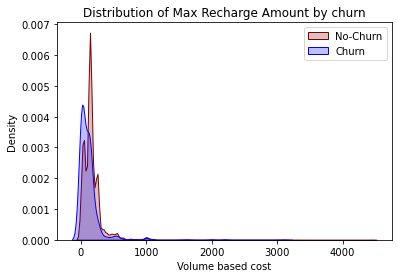

In [28]:
# churn vs max recharge amount
max_rech_plot = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)], color='Maroon', shade = True)
max_rech_plot = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],color="Blue", shade= True)
max_rech_plot.legend(["No-Churn","Churn"],loc='best')
max_rech_plot.set_ylabel('Density')
max_rech_plot.set_xlabel('Volume based cost')
max_rech_plot.set_title('Distribution of Max Recharge Amount by churn')
plt.show()

- The plot clearly indicates the fact that the non-churners are willing to pay subscriptions that cost high. 

#### Principal Component Analysis

In [29]:
df = telecom_hv_cust
df.drop('mobile_number', axis=1, inplace = True)
df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,aon_month
7,3171.480,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,...,15.465,5.0,1185.0,0.0,0.000,0.0,0.0,0.0,0.0,26.733333
8,137.362,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,...,0.000,20.0,122.0,25.0,178.000,0.5,0.5,0.0,0.0,10.500000
21,637.760,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,...,0.000,24.0,50.0,25.0,0.000,0.0,0.0,0.0,0.0,24.000000
23,366.966,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,...,2.675,4.0,89.5,89.5,0.240,0.0,0.0,1.0,0.0,20.133333
33,409.230,0.00,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,...,0.940,10.5,753.5,126.0,72.405,0.0,0.0,4.5,2.0,44.266667


In [30]:
X = df.drop(['churn'], axis=1)
y = df['churn']
df.drop('churn', axis=1, inplace=True)

In [31]:
# Scaling the dataset
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size = 0.3, random_state=1 )

In [33]:
print(X_train.shape)
print(X_test.shape)

(19952, 59)
(8552, 59)


In [34]:
# Handling imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=5)
X_tr,y_tr = sm.fit_resample(X_train,y_train)

In [35]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

Dimension of X_tr Shape: (37666, 59)
Dimension of y_tr Shape: (37666,)
Imbalance in Training dataset: 1.0


In [36]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)
pca.fit(X_tr)

PCA(random_state=100)

In [37]:
X_tr_pca=pca.fit_transform(X_tr)
X_test_pca = pca.transform(X_test)
print(X_tr_pca.shape)
print(X_test_pca.shape)

(37666, 59)
(8552, 59)


In [38]:
from sklearn import metrics
lr_pca = LogisticRegression()
lr_pca.fit(X_tr_pca,y_tr)
y_pred = lr_pca.predict(X_test_pca)
y_pred_df = pd.DataFrame(y_pred)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print("Accuracy :", accuracy_score(y_test,y_pred))

[[6528 1547]
 [  94  383]]
Accuracy : 0.8081150608044901


In [40]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC-1,PC-2,PC-3,Feature
0,0.189335,0.259279,0.147380,arpu_8
1,0.077061,0.216371,-0.088720,onnet_mou_8
2,0.123501,0.232308,0.008725,offnet_mou_8
3,0.389540,-0.196744,-0.062814,roam_ic_mou_8
4,0.378374,-0.127575,-0.089473,roam_og_mou_8
5,0.012710,0.067028,-0.027262,loc_og_t2c_mou_8
6,0.038688,0.163273,0.153478,loc_og_mou_8
7,0.027185,0.029419,0.075040,std_og_t2f_mou_8
8,0.062951,0.260605,-0.142361,std_og_mou_8
9,0.055550,0.104791,0.095682,isd_og_mou_8


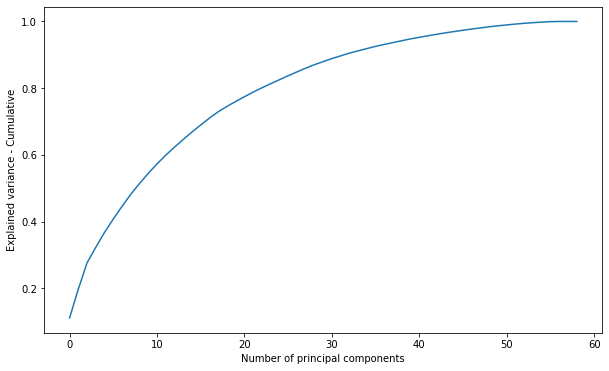

In [41]:
# Checking the variance explained by different PCAs
fig = plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of principal components')
plt.ylabel('Explained variance - Cumulative')
plt.show()

In [42]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
# 36 columns explains 90% of the variance, lets apply PCA with 36 components

array([ 11.08,  19.73,  27.62,  32.29,  36.77,  40.77,  44.57,  48.2 ,
        51.42,  54.48,  57.3 ,  59.93,  62.33,  64.64,  66.88,  69.  ,
        71.06,  72.96,  74.56,  76.04,  77.48,  78.85,  80.14,  81.37,
        82.56,  83.74,  84.89,  86.01,  87.05,  87.98,  88.89,  89.72,
        90.53,  91.22,  91.9 ,  92.57,  93.15,  93.71,  94.26,  94.81,
        95.28,  95.74,  96.2 ,  96.62,  97.01,  97.39,  97.75,  98.1 ,
        98.43,  98.71,  98.98,  99.23,  99.47,  99.65,  99.82,  99.96,
       100.01, 100.01, 100.01])

In [43]:
# PCA with 36 components
pca_36 = PCA(n_components=36)

df_tr_pca_36 = pca_36.fit_transform(X_tr)
print(df_tr_pca_36.shape)

df_test_pca_36 = pca_36.transform(X_test)
print(df_test_pca_36.shape)

(37666, 36)
(8552, 36)


In [44]:
# Running the model using the selected variables

lr_pca1 = LogisticRegression()
lr_pca1.fit(df_tr_pca_36, y_tr)

# Predicted probabilities
y_pred36 = lr_pca1.predict(df_test_pca_36)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred36)

print("Accuracy with 36 PCAs is : ",accuracy_score(y_test,y_pred36))

Accuracy with 36 PCAs is :  0.8037885874649204


In [45]:
print(confusion_matrix(y_test,y_pred36))

[[6501 1574]
 [ 104  373]]


#### Decision Tree

In [46]:
# Considering Decision Tree Analysis
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size = 0.3, random_state=1 )
from imblearn.over_sampling import SMOTE
sm = SMOTE(k_neighbors=5)
X_tr,y_tr = sm.fit_resample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(37666, 59)
(37666,)


In [47]:
# Feature selection 
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)
print(X_lasso.shape)
print(position)

(37666, 32)
[ 0  1  4  6  7  8 10 12 15 16 19 21 22 23 24 25 26 27 30 31 32 34 35 39
 43 44 46 50 53 54 55 58]


In [48]:
lassofeatures = list(df.columns[position])
lassofeatures

['arpu_8',
 'onnet_mou_8',
 'roam_og_mou_8',
 'loc_og_mou_8',
 'std_og_t2f_mou_8',
 'std_og_mou_8',
 'spl_og_mou_8',
 'loc_ic_mou_8',
 'std_ic_mou_8',
 'spl_ic_mou_8',
 'total_rech_num_8',
 'last_day_rch_amt_8',
 'vol_2g_mb_8',
 'monthly_2g_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'sachet_3g_8',
 'aug_vbc_3g',
 'sep_vbc_3g',
 'avg_arpu_av67',
 'avg_onnet_mou_av67',
 'avg_roam_ic_mou_av67',
 'avg_roam_og_mou_av67',
 'avg_std_og_mou_av67',
 'avg_loc_ic_mou_av67',
 'avg_std_ic_t2t_mou_av67',
 'avg_std_ic_mou_av67',
 'avg_total_rech_num_av67',
 'avg_vol_2g_mb_av67',
 'avg_monthly_2g_av67',
 'avg_sachet_2g_av67',
 'aon_month']

In [49]:
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [50]:
from sklearn.tree import DecisionTreeClassifier
tree1 = DecisionTreeClassifier(max_depth=5)
tree1.fit(X_lasso,y_tr)

DecisionTreeClassifier(max_depth=5)

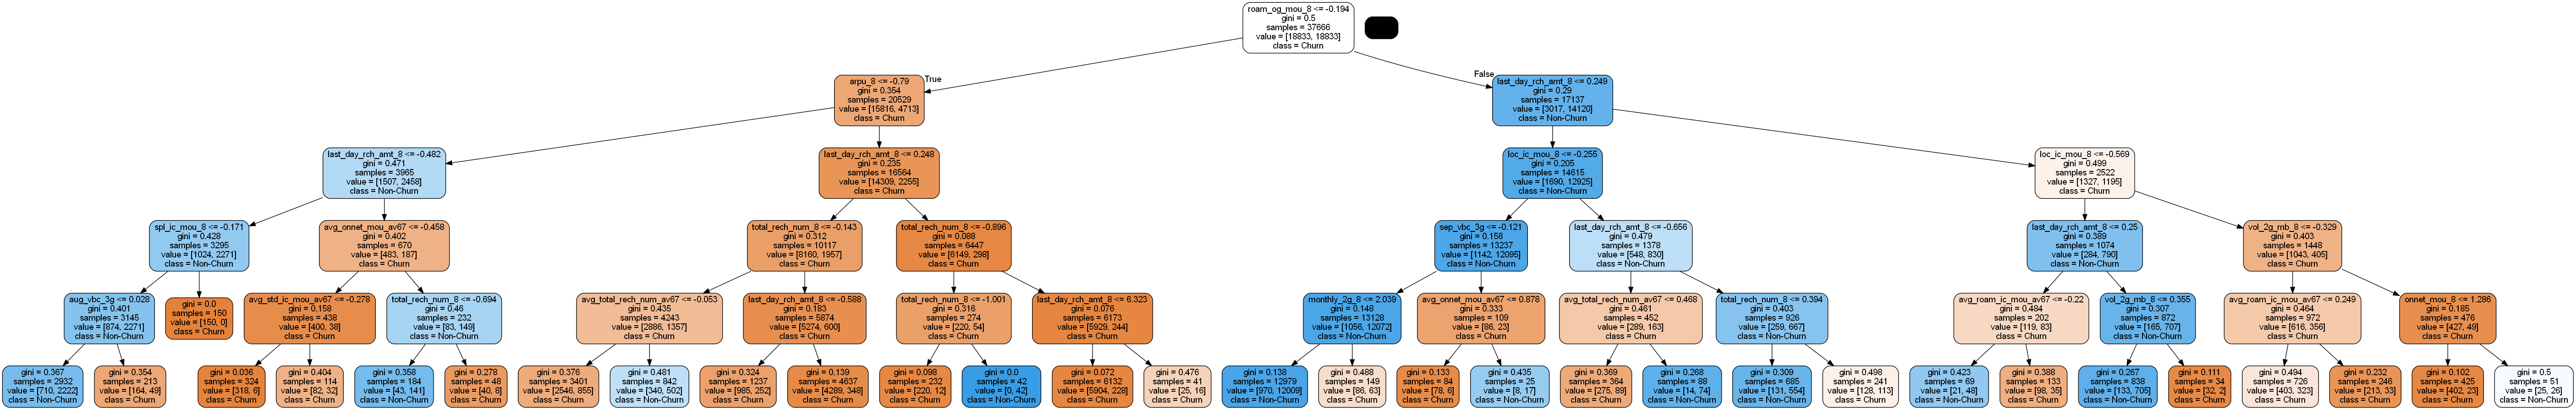

In [51]:
dot_data = StringIO()  

export_graphviz(tree1, out_file=dot_data, filled=True, rounded=True,
                feature_names=lassofeatures, 
                class_names=['Churn', "Non-Churn"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [52]:
# Classification Report
X_test = pd.DataFrame(data=X_test).iloc[:,position]
y_pred2 = tree1.predict(X_test)
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      8075
           1       0.24      0.71      0.36       477

    accuracy                           0.86      8552
   macro avg       0.61      0.79      0.64      8552
weighted avg       0.94      0.86      0.89      8552



In [53]:
accu_tree1 = accuracy_score(y_test,y_pred2)
accu_tree1

0.8594480823199252

In [54]:
print(confusion_matrix(y_test, y_pred2))

[[7011 1064]
 [ 138  339]]


- An accuracy of 0.8469 is achieved from decison tree analysis
- A very high number of false positives is also recorded

In [55]:
# Fine Tuning Hyperparameters
# Fine Tuning Max Depth
parameters = {'max_depth': range(1,45)}
tree1 = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(tree1, parameters, cv = 5, scoring="accuracy", return_train_score=True)
tree.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 45)}, return_train_score=True,
             scoring='accuracy')

In [56]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068839,0.007319,0.000395,0.000791,1,{'max_depth': 1},0.766658,0.800743,0.803266,0.797956,...,0.794776,0.014271,44,0.801805,0.793283,0.792653,0.793980,0.792155,0.794775,0.003568
1,0.118335,0.003895,0.000000,0.000000,2,{'max_depth': 2},0.803557,0.823045,0.826895,0.827559,...,0.822121,0.009519,43,0.828488,0.823648,0.821491,0.822454,0.822022,0.823621,0.002535
2,0.166889,0.007254,0.000196,0.000391,3,{'max_depth': 3},0.804752,0.843356,0.847073,0.847338,...,0.838795,0.017213,42,0.842228,0.845153,0.839379,0.842996,0.843162,0.842583,0.001871
3,0.213972,0.008629,0.000200,0.000399,4,{'max_depth': 4},0.825723,0.853976,0.855967,0.856498,...,0.851113,0.013087,41,0.857062,0.857366,0.849335,0.854047,0.854810,0.854524,0.002890
4,0.254322,0.010462,0.004982,0.006159,5,{'max_depth': 5},0.841120,0.867251,0.868578,0.867915,...,0.863750,0.011557,40,0.874286,0.869047,0.863704,0.868948,0.867122,0.868622,0.003429


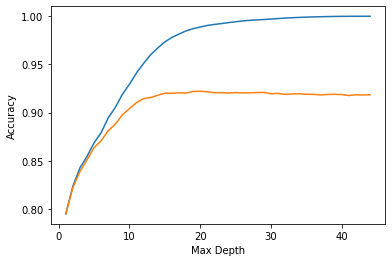

In [57]:
# Accuracy vs max depth
plt.plot(score["param_max_depth"], score["mean_train_score"], label= "train accuracy")
plt.plot(score["param_max_depth"], score["mean_test_score"], label= "test accuracy")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

In [58]:
# Fine Tuning Minimum sample leaf
from sklearn.model_selection import KFold
parameters = {"min_samples_leaf" : range(5,200,20)}
tree1 = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(tree1, parameters, cv = 5, scoring="accuracy", return_train_score=True)
tree.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [59]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.850160,0.026803,0.004135,0.005856,5,{'min_samples_leaf': 5},0.879347,0.922873,0.922076,0.918625,...,0.914168,0.017662,1,0.973682,0.966515,0.967809,0.967345,0.964955,0.968061,0.002974
1,0.694429,0.028075,0.000598,0.001197,25,{'min_samples_leaf': 25},0.864083,0.905217,0.912518,0.906810,...,0.900070,0.018208,2,0.933957,0.921780,0.924601,0.920785,0.919225,0.924070,0.005245
2,0.634170,0.015207,0.000000,0.000000,45,{'min_samples_leaf': 45},0.854659,0.889154,0.899907,0.893004,...,0.888202,0.017578,3,0.911158,0.903196,0.901802,0.905618,0.903760,0.905107,0.003264
3,0.598606,0.033216,0.003132,0.006264,65,{'min_samples_leaf': 65},0.848951,0.887429,0.891544,0.887163,...,0.882999,0.017636,4,0.901732,0.893804,0.889955,0.895298,0.894800,0.895118,0.003802
4,0.569527,0.023076,0.000000,0.000000,85,{'min_samples_leaf': 85},0.844837,0.882517,0.887960,0.881986,...,0.877742,0.016821,5,0.897086,0.890320,0.885109,0.890817,0.889490,0.890564,0.003836


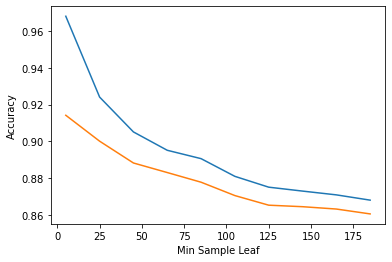

In [60]:
plt.plot(score["param_min_samples_leaf"], score["mean_train_score"], label= "train accuracy")
plt.plot(score["param_min_samples_leaf"], score["mean_test_score"], label= "test accuracy")
plt.xlabel("Min Sample Leaf")
plt.ylabel("Accuracy")
plt.show()

In [61]:
# Fine Tuning minimum sample split
parameters = {'min_samples_split' : range(5,200,20)}
tree1 = DecisionTreeClassifier(criterion="gini", random_state=100)
tree = GridSearchCV(tree1, parameters, cv=5, scoring="accuracy", return_train_score=True)
tree.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [62]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.867259,0.036333,0.006249,0.007653,5,{'min_samples_split': 5},0.883462,0.921280,0.927784,0.924067,...,0.916769,0.016818,1,0.996283,0.993562,0.995055,0.994557,0.993927,0.994677,0.000953
1,0.846752,0.034761,0.003127,0.006254,25,{'min_samples_split': 25},0.874038,0.915306,0.917961,0.916102,...,0.908088,0.017048,2,0.971791,0.966051,0.964823,0.962898,0.960475,0.965207,0.003793
2,0.840704,0.032011,0.003120,0.006240,45,{'min_samples_split': 45},0.871649,0.909465,0.914775,0.910394,...,0.903813,0.016189,3,0.957686,0.947234,0.948329,0.948462,0.942787,0.948900,0.004855
3,0.834232,0.021213,0.000000,0.000000,65,{'min_samples_split': 65},0.869790,0.904952,0.914244,0.906677,...,0.901026,0.015931,4,0.949223,0.937444,0.936747,0.937411,0.934457,0.939057,0.005199
4,0.828189,0.027466,0.006251,0.007655,85,{'min_samples_split': 85},0.867667,0.898845,0.912651,0.901367,...,0.897521,0.015672,5,0.943515,0.928782,0.928683,0.929612,0.926493,0.931417,0.006137


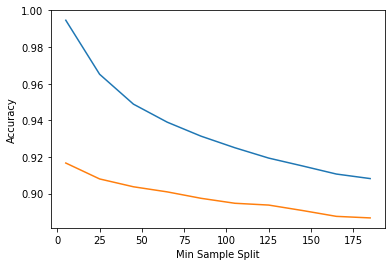

In [63]:
plt.plot(score["param_min_samples_split"], score["mean_train_score"], label= "train accuracy")
plt.plot(score["param_min_samples_split"], score["mean_test_score"], label= "test accuracy")
plt.xlabel("Min Sample Split")
plt.ylabel("Accuracy")
plt.show()

In [64]:
# Parameter Grid
params_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}
tree1 = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = tree1, param_grid = params_grid, 
                          cv = 5, verbose = 1)
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [65]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50)

In [66]:
grid_search.best_score_

0.8944414085148609

In [67]:
# Decision tree with best parameters
finaltree = DecisionTreeClassifier(criterion="gini", random_state=100, max_depth=10, min_samples_leaf=25, min_samples_split=50)
finaltree.fit(X_lasso,y_tr)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [68]:
finaltree.score(X_test, y_test)

0.8838868101028999

- An accuracy of 0.867 is achieved using decison tree analysis

#### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier()
rfmodel.fit(X_lasso,y_tr)
pred_test = rfmodel.predict(X_test)

In [70]:
metrics.accuracy_score(y_test,pred_test)

0.9402478952291862

In [71]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      8075
           1       0.47      0.57      0.52       477

    accuracy                           0.94      8552
   macro avg       0.72      0.77      0.74      8552
weighted avg       0.95      0.94      0.94      8552



In [72]:
print(confusion_matrix(y_test,pred_test))

[[7768  307]
 [ 204  273]]


In [73]:
# Fine Tuning hyperparameters to find optimum depth
parameters = {"max_depth":range(2,20,5)}
rfmodel = GridSearchCV(rfmodel, parameters, cv=5, scoring="accuracy", return_train_score=True)
rfmodel.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [74]:
scores = rfmodel.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.431601,0.021167,0.037632,0.005992,2,{'max_depth': 2},0.817759,0.844551,0.855436,0.836187,...,0.842033,0.014220,4,0.848533,0.844257,0.843627,0.831713,0.845153,0.842657,0.005728
1,3.851484,0.053408,0.065115,0.009578,7,{'max_depth': 7},0.867136,0.893801,0.900836,0.901766,...,0.892503,0.012980,3,0.906545,0.899844,0.899114,0.899744,0.897289,0.900507,0.003155
2,5.949035,0.099664,0.082791,0.004849,12,{'max_depth': 12},0.920228,0.943183,0.950219,0.946369,...,0.942309,0.011425,2,0.970762,0.967411,0.967179,0.967345,0.965851,0.967710,0.001629
3,6.680229,0.082539,0.094203,0.007494,17,{'max_depth': 17},0.939607,0.960573,0.966016,0.965220,...,0.960018,0.010534,1,0.990143,0.989082,0.988551,0.989214,0.988518,0.989102,0.000590


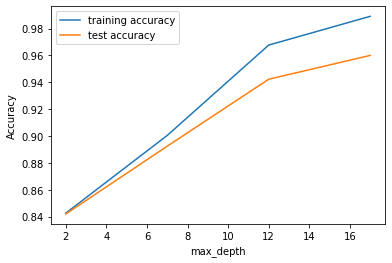

In [75]:
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [76]:
# Fine Tuning hyperparameters to find optimum n estimators
parameters = {'n_estimators':range(100,1500,400)}
rfmodel = RandomForestClassifier(max_depth=4)
rfmodel = GridSearchCV(rfmodel, parameters, cv=5, scoring="accuracy", return_train_score=True)
rfmodel.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_depth=4),
             param_grid={'n_estimators': range(100, 1500, 400)},
             return_train_score=True, scoring='accuracy')

In [77]:
scores = rfmodel.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.347899,0.034190,0.045211,0.006082,100,{'n_estimators': 100},0.837935,0.864729,0.871631,0.865260,...,0.862981,0.013140,4,0.870669,0.867753,0.865098,0.859390,0.865563,0.865695,0.003718
1,11.838278,0.044741,0.224514,0.008083,500,{'n_estimators': 500},0.839129,0.863401,0.874021,0.873357,...,0.865237,0.013784,1,0.873457,0.866459,0.867122,0.865596,0.864468,0.867420,0.003146
2,21.493827,0.276501,0.414958,0.006624,900,{'n_estimators': 900},0.838598,0.864330,0.873623,0.874154,...,0.865158,0.013836,2,0.872893,0.867454,0.866459,0.866426,0.865795,0.867805,0.002599
3,31.809969,0.657732,0.604803,0.029541,1300,{'n_estimators': 1300},0.839395,0.863799,0.872693,0.872693,...,0.864706,0.013221,3,0.873822,0.867288,0.866160,0.865795,0.865529,0.867719,0.003110


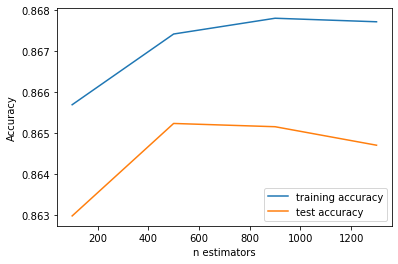

In [78]:
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [79]:
# Fine Tuning minimum sample leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_leaf':range(50,400,10)}
rfmodel = RandomForestClassifier()
rfmodel = GridSearchCV(rfmodel, parameters, cv=5, scoring="accuracy", return_train_score=True)
rfmodel.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': range(50, 400, 10)},
             return_train_score=True, scoring='accuracy')

In [80]:
scores = rfmodel.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.490043,0.076673,0.088334,0.007501,50,{'min_samples_leaf': 50},0.875498,0.905615,0.911722,0.910793,...,0.902565,0.013693,1,0.917828,0.912057,0.910497,0.909568,0.909037,0.911797,0.003185
1,5.281663,0.110173,0.083577,0.005898,60,{'min_samples_leaf': 60},0.872843,0.899376,0.906146,0.906545,...,0.898556,0.013191,2,0.912784,0.906813,0.903760,0.905386,0.905486,0.906846,0.003123
2,5.197951,0.104859,0.079376,0.002888,70,{'min_samples_leaf': 70},0.869259,0.896190,0.904288,0.904819,...,0.896194,0.013927,3,0.908171,0.900740,0.900010,0.904490,0.902433,0.903169,0.002939
3,5.117800,0.074486,0.080951,0.008905,80,{'min_samples_leaf': 80},0.868596,0.894995,0.900704,0.900704,...,0.893804,0.012934,4,0.905947,0.898649,0.897388,0.898284,0.898815,0.899817,0.003105
4,4.919966,0.083924,0.087318,0.014672,90,{'min_samples_leaf': 90},0.865012,0.890615,0.902960,0.899243,...,0.891335,0.013766,5,0.905449,0.896957,0.895165,0.894468,0.896028,0.897613,0.004006


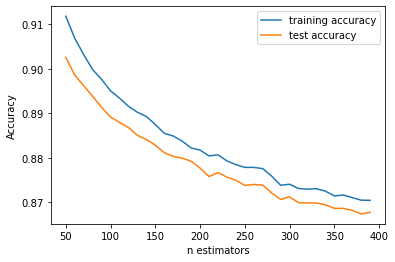

In [81]:
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [82]:
# Fine Tuning Min Samples Split
parameters = {'min_samples_split':range(100,500,25)}
rfmodel = RandomForestClassifier()
rfmodel = GridSearchCV(rfmodel, parameters, cv=5, scoring="accuracy", return_train_score=True)
rfmodel.fit(X_lasso,y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': range(100, 500, 25)},
             return_train_score=True, scoring='accuracy')

In [83]:
scores = rfmodel.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.947524,0.120076,0.093711,0.000008,100,{'min_samples_split': 100},0.893815,0.922873,0.930041,0.928315,...,0.920964,0.013819,1,0.945175,0.939203,0.936648,0.935652,0.938141,0.938964,0.003336
1,6.900421,0.104161,0.094613,0.001797,125,{'min_samples_split': 125},0.887311,0.916368,0.922474,0.925793,...,0.915468,0.014477,2,0.936513,0.930707,0.929347,0.931305,0.930043,0.931583,0.002550
2,6.818655,0.141311,0.091940,0.003555,150,{'min_samples_split': 150},0.884125,0.912651,0.920749,0.918359,...,0.911167,0.013814,3,0.932298,0.926061,0.923804,0.924369,0.924800,0.926266,0.003106
3,6.634649,0.132040,0.087473,0.007663,175,{'min_samples_split': 175},0.879214,0.909200,0.918757,0.916501,...,0.908194,0.014861,4,0.926391,0.918096,0.919988,0.919557,0.919656,0.920738,0.002900
4,6.528051,0.087798,0.090592,0.006253,200,{'min_samples_split': 200},0.881869,0.910660,0.914642,0.914908,...,0.907557,0.012962,5,0.924598,0.918694,0.915641,0.915508,0.917400,0.918368,0.003331


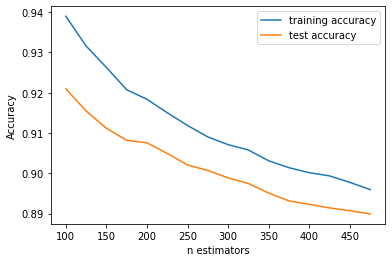

In [84]:
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [86]:
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      5399
           1       0.67      0.19      0.29       302

    accuracy                           0.95      5701
   macro avg       0.81      0.59      0.63      5701
weighted avg       0.94      0.95      0.94      5701

[[5371   28]
 [ 245   57]]


In [87]:
print(metrics.accuracy_score(y_test, prediction_test))

0.9521136642694265


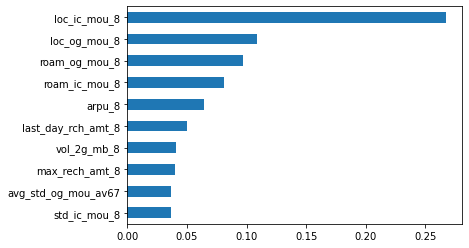

In [88]:
# list of important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')
plt.show()

Conclusions 

- loc_ic_mou_8, loc_og_mou_8 & roam_og_mou_8 have been revealed as the top predictor variables to predict churn. 
- Tenured customers are not churning and are readily availing the services
- Customers with a tenure of less than 4 years are more likely to churn
- Random Forest approach produced the best results with an accuracy of 95.21%


